## Loading the Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/DM-Assignment-Dataset/daily-minimum-temperatures-in-me.csv'
temperature_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
temperature_data.head()

,Date,Daily minimum temperatures
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


## Data Preprocessing

In [4]:
# Step 1: Handle Missing Values
# Checking for missing or inconsistent data
missing_values_check = temperature_data.isnull().sum()
inconsistent_data_check = temperature_data[temperature_data['Daily minimum temperatures'] == '?']

# Step 2: Data Type Conversion
# Converting 'Date' column to datetime type
temperature_data['Date'] = pd.to_datetime(temperature_data['Date'])

# Handle inconsistent data by replacing '?' with NaN and then converting the column to numeric
temperature_data['Daily minimum temperatures'] = pd.to_numeric(temperature_data['Daily minimum temperatures'], errors='coerce')

# Recheck for missing values after conversion
missing_values_after_conversion = temperature_data.isnull().sum()

(missing_values_check, inconsistent_data_check, missing_values_after_conversion)

(Date                          0
 Daily minimum temperatures    0
 dtype: int64,
 Empty DataFrame
 Columns: [Date, Daily minimum temperatures]
 Index: [],
 Date                          0
 Daily minimum temperatures    3
 dtype: int64)

In [5]:
# Data Normalization: Assessing the need based on statistical properties
temperature_statistics = temperature_data.describe()

temperature_statistics

,Daily minimum temperatures
count,3647.000000
mean,11.186647
std,4.061671
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


## Visualization

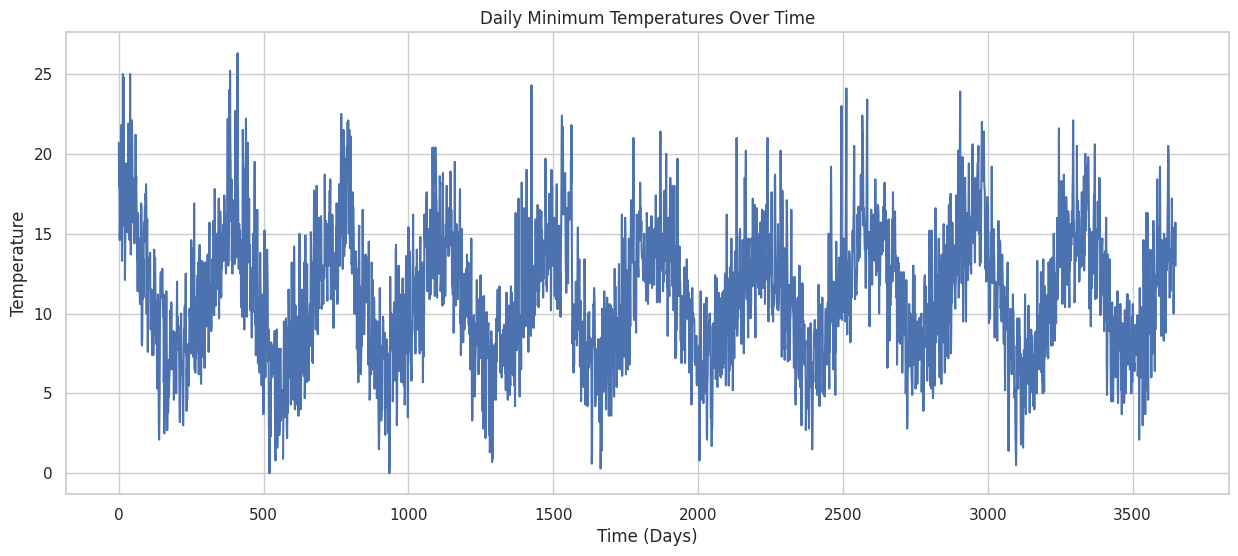

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Statistical Summary already done, now focusing on visualization for trend, seasonality, and outliers

# Plotting the temperature data to observe any trends or patterns
plt.figure(figsize=(15, 6))
plt.plot(temperature_data['Daily minimum temperatures'])
plt.title('Daily Minimum Temperatures Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Temperature')
plt.show()

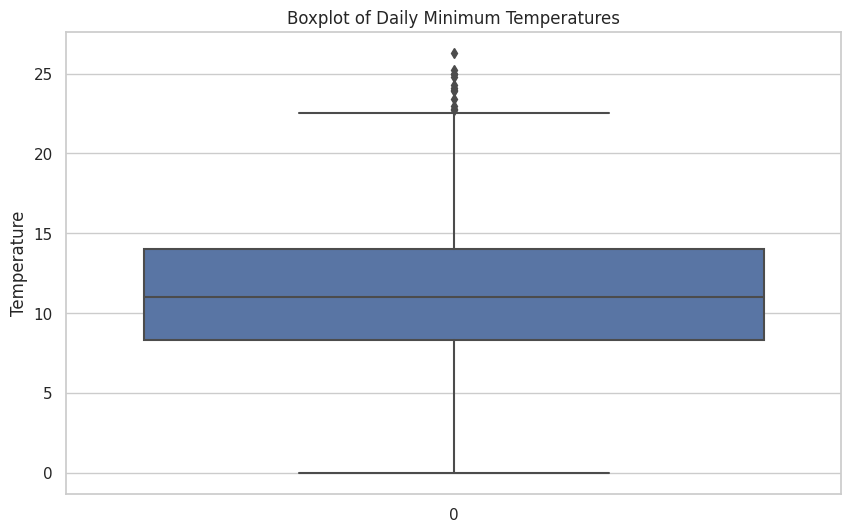

In [8]:
# Boxplot for detecting outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=temperature_data['Daily minimum temperatures'])
plt.title('Boxplot of Daily Minimum Temperatures')
plt.ylabel('Temperature')
plt.show()

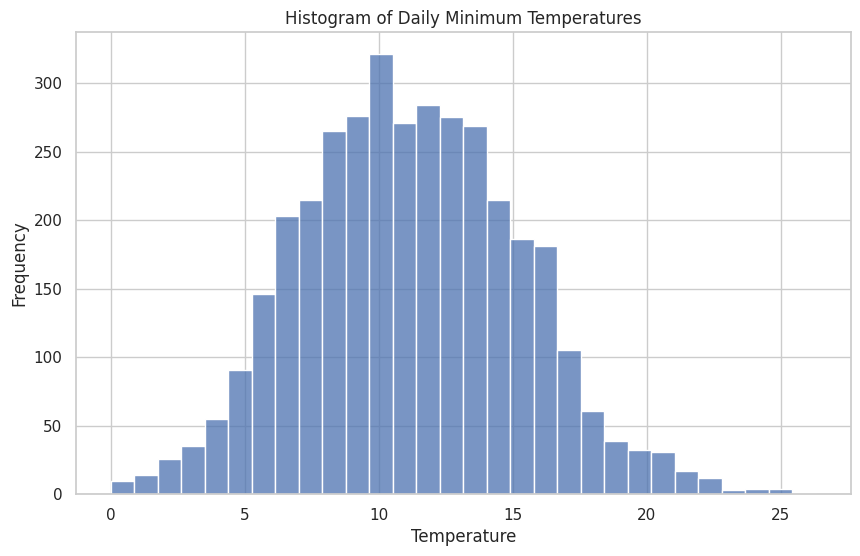

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(temperature_data['Daily minimum temperatures'], kde=False, bins=30)
plt.title('Histogram of Daily Minimum Temperatures')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

<ipython-input-10-6fdefc177577>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(temperature_data['Daily minimum temperatures'], shade=True)


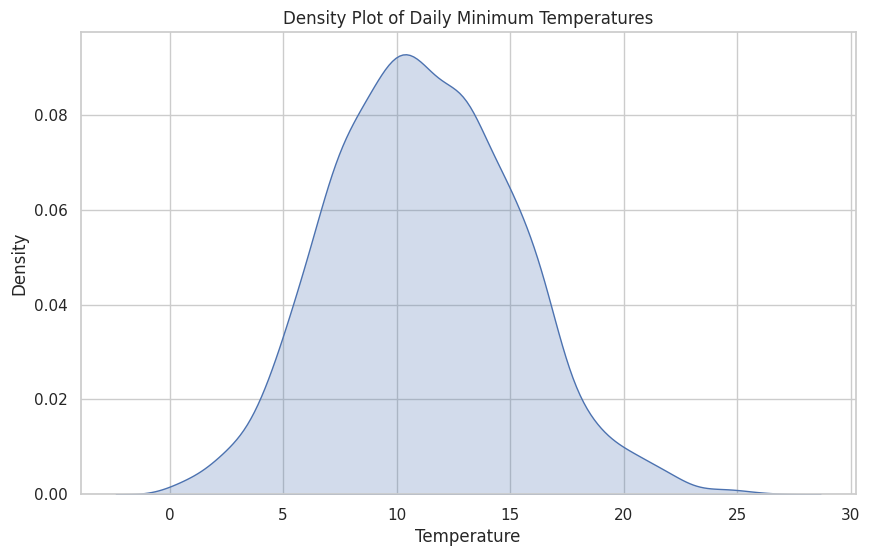

In [10]:
# Density Plot of the temperature data
plt.figure(figsize=(10, 6))
sns.kdeplot(temperature_data['Daily minimum temperatures'], shade=True)
plt.title('Density Plot of Daily Minimum Temperatures')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.show()

## Applying a Pretrained Model for Clustering

### Preparing the Data for LSTM
Before feeding the data into an LSTM network, it needs to be properly formatted and normalized.

In [11]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd


# Fill missing values
temperature_filled = temperature_data['Daily minimum temperatures'].fillna(temperature_data['Daily minimum temperatures'].mean())

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
temperature_scaled = scaler.fit_transform(temperature_filled.values.reshape(-1, 1))

# Function to create a dataset for LSTM
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define the time_step
time_step = 1
X, y = create_dataset(temperature_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshaping for LSTM [samples, time steps, features]


### Building and Training the LSTM Model
Construct an LSTM model to learn from the temperature data.

In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Building the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X, y, epochs=100, batch_size=32, verbose=1)


Epoch 1/100
114/114 [==============================] - 5s 4ms/step - loss: 0.0560
Epoch 2/100
114/114 [==============================] - 1s 5ms/step - loss: 0.0115
Epoch 3/100
114/114 [==============================] - 1s 7ms/step - loss: 0.0100
Epoch 4/100
114/114 [==============================] - 1s 7ms/step - loss: 0.0100
Epoch 5/100
114/114 [==============================] - 1s 7ms/step - loss: 0.0099
Epoch 6/100
114/114 [==============================] - 1s 7ms/step - loss: 0.0098
Epoch 7/100
114/114 [==============================] - 1s 7ms/step - loss: 0.0099
Epoch 8/100
114/114 [==============================] - 1s 7ms/step - loss: 0.0099
Epoch 9/100
114/114 [==============================] - 1s 7ms/step - loss: 0.0100
Epoch 10/100
114/114 [==============================] - 1s 7ms/step - loss: 0.0099
Epoch 11/100
114/114 [==============================] - 1s 7ms/step - loss: 0.0098
Epoch 12/100
114/114 [==============================] - 1s 5ms/step - loss: 0.0098
Epoch 13/100


### Feature Extraction
Extract features from the LSTM model.

In [13]:
# Get the output of one of the LSTM layers
from keras.models import Model

layer_name = 'lstm_2'  # This is the last LSTM layer in our model
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X)
intermediate_output


114/114 [==============================] - 6s 10ms/step


array([[ 0.0768651 , -0.06047623,  0.0551261 , ...,  0.02441192,
         0.03393218, -0.06115921],
       [ 0.06741463, -0.05376225,  0.04920152, ...,  0.02281785,
         0.03114293, -0.05497098],
       [ 0.07054663, -0.05600436,  0.05119977, ...,  0.02336755,
         0.03209661, -0.05708613],
       ...,
       [ 0.05308949, -0.04333621,  0.03970159, ...,  0.0200773 ,
         0.02647519, -0.04464507],
       [ 0.05157185, -0.04221738,  0.03866453, ...,  0.01976742,
         0.02595459, -0.04349711],
       [ 0.05119154, -0.04193663,  0.03840381, ...,  0.01968923,
         0.02582342, -0.04320801]], dtype=float32)

### Clustering the Extracted Features
Use a clustering algorithm like K-Means on the features extracted by the LSTM.

In [15]:
from sklearn.cluster import KMeans

# Apply K-Means clustering on the extracted features
kmeans = KMeans(n_clusters=3)
kmeans.fit(intermediate_output)

# Getting the cluster labels
cluster_labels = kmeans.labels_

cluster_labels


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 1, 1, ..., 1, 0, 0], dtype=int32)

## Model Evaluation

Epoch 1/100
92/92 [==============================] - 9s 21ms/step - loss: 0.0101 - val_loss: 0.0082
Epoch 2/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0101 - val_loss: 0.0085
Epoch 3/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0101 - val_loss: 0.0085
Epoch 4/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0102 - val_loss: 0.0082
Epoch 5/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0102 - val_loss: 0.0082
Epoch 6/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0101 - val_loss: 0.0085
Epoch 7/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0101 - val_loss: 0.0085
Epoch 8/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0104 - val_loss: 0.0083
Epoch 9/100
92/92 [==============================] - 1s 10ms/step - loss: 0.0101 - val_loss: 0.0082
Epoch 10/100
92/92 [==============================] - 1s 10ms/step - loss: 0.0101 - val_loss: 0.0082
Epoch 

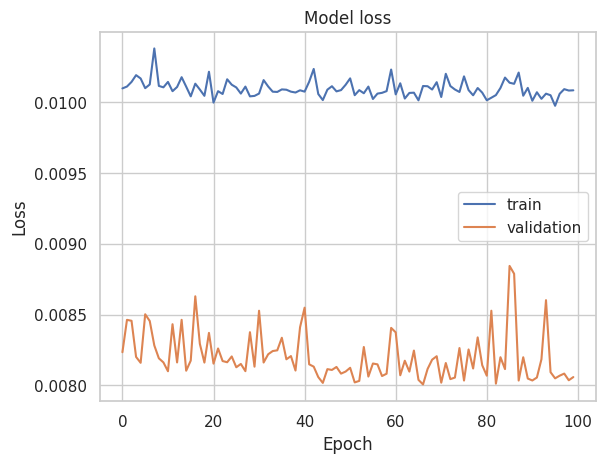

In [19]:
# Assuming you have already trained your model
history = model.fit(X, y, epochs=100, batch_size=32, verbose=1, validation_split=0.2)

# Plotting training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
